# Set up model and hyperparameters

In [6]:
from models.WaveNetVAE.WaveVae import WaveNetVAE

import torch
from torch.utils.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

"""
Hyperparameters
"""

batchsize = 2
device=['cuda:3', 'cuda:4']
input_size = (13, 112)
upsamples = [2, 2, 2, 2, 2, 2, 2, 2]
zsize = 32

WaveVAE = WaveNetVAE(input_size,
                     num_hiddens = 768,
                     upsamples = upsamples,
                     zsize = zsize,
                    out_channels = 256,
                    devices = device)

# WaveVAE.to(device)


WaveNet Receptive Field:  4093


## Load datasets

In [12]:
from models.WaveNetVAE.WVData import WVDataset

# VAEDataset = WVDataset(audio_path = "./dataset/LJSpeech-1.1/wavs",
#                        length = 4096,
#                        skip_size = 4096 // 2,
#                        sample_rate = 24000,
#                        max_files = 5000,
#                        win_length = 400)

val_VAEDataset = WVDataset(audio_path = "./dataset/val",
                       length = 4096,
                       skip_size = 4096 // 2,
                       sample_rate = 24000,
                       max_files = 10,
                       win_length = 200)

# VAEDataloader = DataLoader(VAEDataset,
#                            batch_size = batchsize,
#                            shuffle = True)

val_VAEDataloader = DataLoader(val_VAEDataset,
                           batch_size = batchsize,
                           shuffle = False)

Loading and preprocessing files to dataset.:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

# Test tensor

Trying tensors with sizes:
Onehot size:  torch.Size([2, 4096]) | MFCC size:  torch.Size([2, 13, 26]) | Target size:  torch.Size([2, 4097])


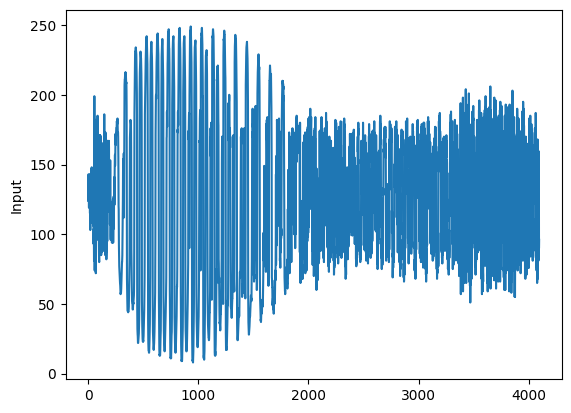

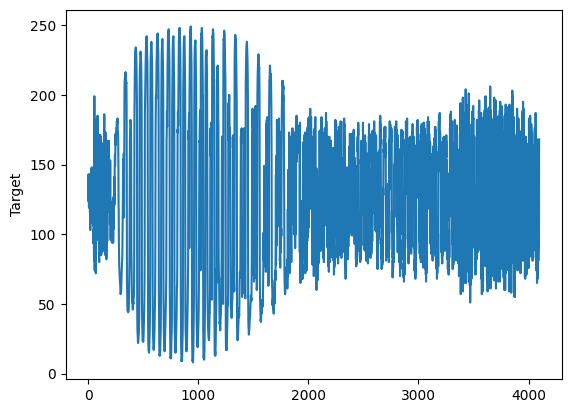

Target value:  168  | Input Value:  96
torch.Size([2, 4097])
Before downsample:  torch.Size([2, 768, 26])
After downsample:  torch.Size([2, 768, 13])
X size before wavenet:  torch.Size([2, 4096])
Condition before upsampling:  torch.Size([2, 768, 13])
Condition and x after c upsampling:  torch.Size([2, 768, 3328]) torch.Size([2, 4096])


AssertionError: 

In [13]:
import torchaudio
import matplotlib.pyplot as plt

# loss_fn = torch.nn.MSELoss()
loss_fn = torch.nn.CrossEntropyLoss(reduction='none')

onehot, mfcc, target, oht = next(iter(val_VAEDataloader))
onehot = onehot.to(device[0])
mfcc = mfcc.to(device[0])
target = target.to(device[0])

print("Trying tensors with sizes:")
print("Onehot size: ", onehot.size(), "| MFCC size: ", mfcc.size(), "| Target size: ", target.size())

plt.plot(torch.squeeze(onehot[0]).cpu().numpy())
plt.ylabel('Input')
plt.show()

plt.plot(torch.squeeze(target[0]).cpu().numpy())
plt.ylabel('Target')
plt.show()



print("Target value: ", target[0, -1].item(), " | Input Value: ", onehot[0, -1].item())

# target = torch.unsqueeze(torch.unsqueeze(target[:, -1], 1), 1)
print(target.size())

output, _, _ = WaveVAE(onehot, mfcc, False, True)
output = output.transpose(2,1)
print("Tensors passed through model succesfully", output.size())

# reconstruction_loss = torch.mean(loss_fn(torch.squeeze(output), torch.squeeze(target)[:, 1:])[-1], 0)

print(output[0, 4095:].size(), target[0, 4096:].contiguous().view(-1).size())
print(torch.argmax(output[0, 4095:].squeeze()), target[0, -1].squeeze().item(), onehot[0, -1].squeeze().item())
print(output[0, -1].cpu())

reconstruction_loss = loss_fn(output[0, -1] * 100, target[0, -1])
print("Reconstruction loss =", reconstruction_loss.item())

print('OHT Size: ', oht.size())

print(oht[0, -1])
print(target[0, -1])
reconstruction_loss = loss_fn(oht[0, -1].type(torch.FloatTensor).to(device) * 10, target[0, -1])
print("Reconstruction loss =", reconstruction_loss.item())

# onehot = torch.nn.functional.sigmoid(onehot[0, :, -1])
# output = torch.nn.functional.sigmoid(output[0, :, -1])
# onehotmax = torch.argmax(onehot)
# outputmax = torch.argmax(output)




# Start training

In [ ]:
from models.WaveNetVAE.train import train
from torch.utils.tensorboard import SummaryWriter
import warnings
warnings.filterwarnings("ignore")
writer = SummaryWriter()

train(WaveVAE, VAEDataloader, val_VAEDataloader,
      writer = writer,
      learning_rate = 0.00001,
      epoch_amount = 100,
      logs_per_epoch = 25,
      kl_anneal = 0.01,
      max_kl = 0.5,
      device = device[0],
     export_path = './exports')


In [3]:
torch.save(WaveVAE.state_dict(), './modeltest')

# Generate Audio

In [1]:
from models.WaveNetVAE.WaveVae import WaveNetVAE
from models.WaveNetVAE.WVData import WVDataset
import torch
from torch.utils.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

"""
Hyperparameters
"""

learning_rate = 0.000001
batchsize = 4
device=['cuda:3','cuda:4']
input_size = (40, 112)
upsamples = [2, 2, 2, 2, 2, 2, 2, 2]
zsize = 32

WaveVAE = WaveNetVAE(input_size,
                     num_hiddens = 768,
                     upsamples = upsamples,
                     zsize = zsize,
                    out_channels = 256)

# WaveVAE.to(device)

WaveVAE.load_state_dict(torch.load('./exports_leaky/2023-05-171'))

WaveNet Receptive Field:  4093


<All keys matched successfully>

In [ ]:
val_VAEDataset = WVDataset(audio_path = "../ConvDenoiser_Old/testdata",
                       length = 4096,
                       skip_size = 1,
                       sample_rate = 24000,
                       max_files = 1,
                       win_length = 128,
                          is_generating=True)

val_VAEDataloader = DataLoader(val_VAEDataset,
                           batch_size = 1,
                           shuffle = False)
with torch.no_grad():
    generated_audio = WaveVAE.inference(val_VAEDataloader, size = 4096, device = device)

Loading and preprocessing files to dataset.:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

torch.Size([1, 1, 4096])


  0%|          | 0/16384 [00:00<?, ?it/s]

In [5]:
import IPython
import torchaudio
print(generated_audio.size())
transform = torchaudio.transforms.MuLawDecoding(quantization_channels=256)
generated_audio_proc = generated_audio
decoded = transform(generated_audio_proc)
IPython.display.display(IPython.display.Audio(decoded.squeeze().detach().cpu().numpy(), rate = 16000))

torch.Size([1, 8192])


torch.Size([1, 4096])


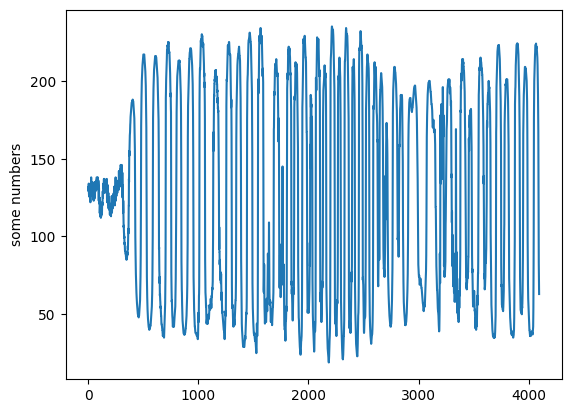

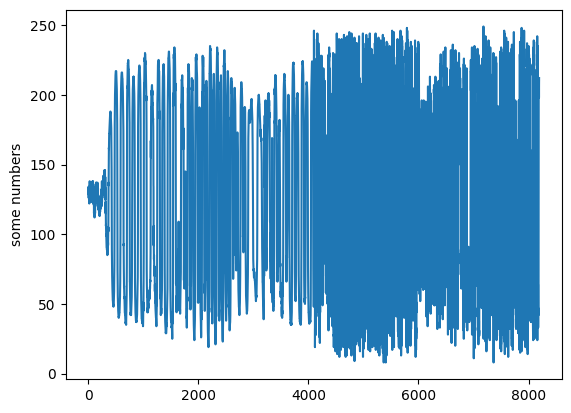

In [4]:
onehot, mfcc, target, _ = next(iter(val_VAEDataloader))

import matplotlib.pyplot as plt
print(onehot[:, -4096:].size())
plt.plot(torch.squeeze(onehot[:, -4096:]).numpy())
plt.ylabel('some numbers')
plt.show()

plt.plot(torch.squeeze(generated_audio_proc.cpu()).numpy())
plt.ylabel('some numbers')
plt.show()